In [3]:
import open3d as o3d
import cv2
import sys
import numpy as np
import argparse
import math
import os
from pathlib import Path
import sklearn.cluster as cluster
from sklearn import metrics
from matplotlib import pyplot as plt

radius = 18
depth = -0.2
loop = 3
RADUIS = 18
DEPTH = -0.2
RANGE = 5
K = 0.5



In [4]:
# idx = '017579'
# pcd_path = '/home/newDisk/tool/carla_dataset_tool/dataset/training/velodyne/'+idx+'.bin'
pcd_path = '/home/newDisk/cadcd/snow_01.bin'

pre_point = np.fromfile(str(pcd_path), dtype=np.dtype([
                                    ('x', np.float32),
                                    ('y', np.float32),
                                    ('z', np.float32),
                                    ('intensity', np.float32),
                                ]) ,count=-1)

pcd = np.array([list(elem) for elem in pre_point])


select_point = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) < radius]
select_point = select_point[select_point[:,2] > depth]

# make the selected point into a polar coordinate
theta = np.arctan2(select_point[:,1], select_point[:,0])
r = np.sqrt(select_point[:,0]**2 + select_point[:,1]**2)
# theta to degree
theta = theta*180/math.pi

In [5]:
DB = cluster.DBSCAN(eps=1.5, min_samples=15)

In [6]:
def calculate_alpha_beta(pcd,DB,loop=3):
    RADUIS = 18
    DEPTH = -0.2
    RANGE = 5
    K = 0.5
    # select probable points
    select_point = pcd[np.sqrt(pcd[:,0]**2 + pcd[:,1]**2) < RADUIS]
    select_point = select_point[select_point[:,2] > DEPTH]
    theta = np.arctan2(select_point[:,1], select_point[:,0])
    r = np.sqrt(select_point[:,0]**2 + select_point[:,1]**2)
    theta = theta*180/math.pi
    select_point_polar = np.array([theta, r]).T


    for _ in range(loop):
        if len(select_point_polar) == 0:
            select_point_polar = last_select_point_polar
            break
        DB.fit(select_point_polar[:,0:2])
        cls_labels = DB.labels_
        n_clusters_ = len(set(cls_labels)) - (1 if -1 in cls_labels else 0)
        label_point = {i: select_point_polar[cls_labels==i] for i in range(n_clusters_)}
        label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
        label_range = sorted(label_range.items(), key=lambda x:x[1][0])

        # check if the cluster is a obstacle, use near points
        near_points = {-1:0}
        thetas,rs = select_point_polar[:,0], select_point_polar[:,1]
        for [k,v] in label_range:
            mask = np.logical_and(thetas>=v[0], thetas<=v[1])
            near_points[k] = np.sum(rs[mask]<RANGE)
            cls_labels[mask] = k
        near_points[-1] = len(select_point_polar) - sum(near_points.values())

        if len(near_points) == 1:
            break

        label_rho = {k: v/(label_range[k][1][1]-label_range[k][1][0]) for k,v in near_points.items()}
        label_length = {k: label_range[k][1][1]-label_range[k][1][0] for k in label_rho.keys()}
        max_item = max(label_length.items(), key=lambda x:x[1])
        origin_length = 360 - sum(label_length.values())
        if origin_length < max_item[1]:
            origin_length = max_item[1]
            label_rho.pop(max_item[0])
            label_length.pop(max_item[0])
            near_points[-1] = near_points[max_item[0]]

        base_rho = K * near_points[-1]/origin_length
        drop_key = [k for k, v in label_rho.items() if v < base_rho]

        # drop the points in the obstacle cluster
        indice = [i for i in range(select_point_polar.shape[0]) if cls_labels[i] not in drop_key]
        last_select_point_polar = select_point_polar
        select_point_polar = select_point_polar[indice]

    DB.fit(select_point_polar)
    labels = DB.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    label_count = {}
    label_point = {}
    for i in range(n_clusters_):
        label_count[i] = np.sum(labels==i)
        label_point[i] = select_point_polar[labels==i]
    
    label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
    length = sum([v[1]-v[0] for k,v in label_range.items()]) if len(label_range) > 0 else 360
    alpha = select_point_polar.shape[0]/length

    cal_pcd = pcd[pcd[:,3]!=0]
    beta_all = -np.log(cal_pcd[:,3]) / np.sqrt(cal_pcd[:,0]**2+cal_pcd[:,1]**2+cal_pcd[:, 2]**2)
    beta = np.mean(beta_all)

    return alpha, beta, length

In [7]:
root_path = '/home/newDisk/tool/carla_dataset_tool/dataset'

file_idx_path = os.path.join(root_path, 'ImageSets/S3')

# there's 4 txt files in the folder, named 0.txt, 1.txt, 2.txt, 3.txt, seperately read them
idx_lists = [[],[],[],[]]
for i in range(4):
    txt_path = os.path.join(file_idx_path, str(i)+'.txt')
    with open(txt_path) as f:
        idx_lists[i] = f.readlines()
        idx_lists[i] = [x.strip() for x in idx_lists[i]]

    idx_lists[i].sort()

print(idx_lists[0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/newDisk/tool/carla_dataset_tool/dataset/ImageSets/S3/0.txt'

In [ ]:

alphas = [[],[],[],[]]
betas = [[],[],[],[]]


for i in range(len(idx_lists)):
    sub_list = idx_lists[i]
    for idx in sub_list:
        print(idx)
        pcd_path = os.path.join(root_path, 'training/velodyne', idx+'.bin')
        pcd = np.fromfile(str(pcd_path), dtype=np.dtype([
                                    ('x', np.float32),
                                    ('y', np.float32),
                                    ('z', np.float32),
                                    ('intensity', np.float32),
                                ]) ,count=-1)
        pcd = np.array([list(elem) for elem in pcd])
        alpha, beta, length = calculate_alpha_beta(pcd, DB, loop=loop)
        alphas[i].append(alpha)
        betas[i].append(beta)


017579
017588
017597
017600
017606
017609
017615
017618
017624
017627
017630
017636
017642
017645
017651
017660
017669
017672
017705
017747
017753
017762
017768
017771
017783
017786
017789
017795
017798
017804
017807
017813
017819
017822
017825
017837
017840
017843
017867
017873
017882
017885
017897
017909
017915
017918
017924
017927
017930
017933
017936
017942
017945
017948
017951
017957
017966
017972
017975
017978
017993
017996
018002
018005
018008
018011
018020
018023
018029
018047
018053
018056
018059
018062
018071
018080
018089
018092
018098
018104
018107
018113
018119
018125
018134
018140
018146
018152
018155
018161
018167
018170
018176
018182
018185
018194
018200
018203
018206
018209
018212
018215
018221
018233
018236
018242
018248
018254
018266
018272
018275
018281
018284
018287
018302
018326
018332
018353
018365
018368
018371
018383
018386
018389
018392
018398
018401
018419
018425
018428
018434
018437
018443
018446
018452
018455
018458
018470
018476
018479
018482
018485
018491

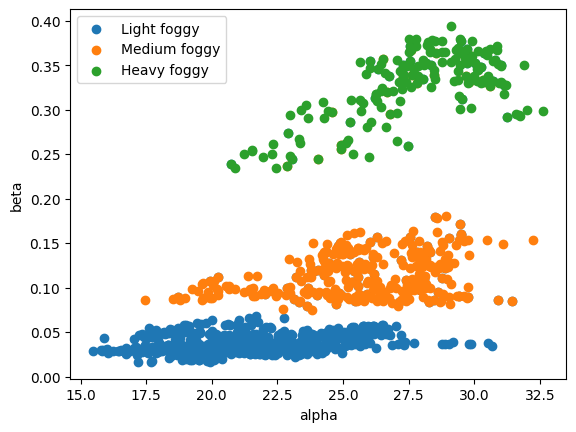

In [ ]:
# draw the alpha beta scatter, use different color to represent different sub list
fig, ax = plt.subplots()
# for i in range(len(alphas)):
#     ax.scatter(alphas[i], betas[i], label=str(i))
# ax.scatter(alphas[0], betas[0], label='No foggy')
ax.scatter(alphas[1], betas[1], label='Light foggy')
ax.scatter(alphas[2], betas[2], label='Medium foggy')
ax.scatter(alphas[3], betas[3], label='Heavy foggy')
ax.legend()
# show x and y axis
plt.xlabel('alpha')
plt.ylabel('beta')

plt.show()


In [ ]:
# save the alpha beta to txt file
a_b_path = './ab/'
for i in range(4):
    with open(a_b_path+str(i)+'.txt', 'w') as f:
        for j in range(len(alphas[i])):
            f.write(str(alphas[i][j])+' '+str(betas[i][j])+'\n')

In [ ]:
# label_range = {i: [np.min(label_point[i][:,0]), np.max(label_point[i][:,0])] for i in range(n_clusters_)}
# length = sum([v[1]-v[0] for k,v in label_range.items()]) if len(label_range) > 0 else 360
# alpha = select_point_polar.shape[0]/length

# cal_pcd = pcd[pcd[:,3]!=0]
# beta_all = -np.log(cal_pcd[:,3]) / np.sqrt(cal_pcd[:,0]**2+cal_pcd[:,1]**2+cal_pcd[:, 2]**2)
# beta = np.mean(beta_all)

# print('length: ', length)
# print('alpha: ', alpha)
# print('beta: ', beta)

In [ ]:
# # 将result_point_polar转换为result_point
# result_point = []
# for i in range(select_point_polar.shape[0]):
#     theta = select_point_polar[i,0]
#     r = select_point_polar[i,1]
#     x = r*math.cos(theta*math.pi/180)
#     y = r*math.sin(theta*math.pi/180)
#     result_point.append([x, y, 0])
# result_point = np.array(result_point)

# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 6))
# ax1.scatter(select_point[:,0], select_point[:,1])
# ax1.set_title('origin point')
# ax2.scatter(result_point[:,0], result_point[:,1])
# ax2.set_title('result point')
# # set figure title
# fig.suptitle('valid length='+str(origin_length))